In [4]:
print(10e-8-1/10000000)

0.0


In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import rpy2
%reload_ext rpy2.ipython
import time
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from pygam import LogisticGAM
from pygam.utils import generate_X_grid
from copy import copy
from progressbar import ProgressBar
from tabulate import tabulate

In [2]:
df = pd.read_csv('marketing.csv')
X_names = pd.get_dummies(df.iloc[:,:-1]).columns
X = pd.get_dummies(df.iloc[:,:-1])
y = np.where(df['y'] == 'yes', 1, 0)
X_train, X_tv, y_train, y_tv = train_test_split(
    X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tv, y_tv, test_size=0.5, random_state=1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(27126, 27) (9042, 27) (9043, 27)
(27126,) (9042,) (9043,)


In [94]:
def metrics_bundle(index, clf, y_test, y_pred, p_pred):
    # misclf rate
    misclf = 1-accuracy_score(
        y_test, y_pred, normalize=1)
    # top1k success rate
    top1k_indices = np.argsort(-p_pred)[:1000]
    success_rate = sum(y_test[list(top1k_indices)])/1000
    # auc
    fpr, tpr, _ = roc_curve(y_test, p_pred)
    auc_score = auc(fpr, tpr)
    roc = [fpr, tpr]
    # oob error
    oob_error = np.nan
    if hasattr(clf, 'oob_score_'):
        oob_error = 1 - clf.oob_score_
    # clf position on roc curve
    est, truth = y_pred.astype(bool), y_test.astype(bool)
    n, p = len(est), np.sum(truth)
    fp = np.sum(est & (~truth))
    fn = np.sum(truth & (~est))
    tp = p - fn; tn = n - p - fp
    sens = tp/p; spec = tn/(n-p)
    roc_loc = [1-spec, sens]
    return [index, misclf, oob_error, 
            auc_score, success_rate], roc, roc_loc

def fit_and_compare(clfs, X_train, y_train, 
                    X_test, y_test, 
                    refit='all', silent=[]):
    table = []
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    for i, (name, clf) in enumerate(clfs):
        if i in silent: continue
        if refit=='all' or i in refit:
            print("Fitting", name+'...')
            clf.fit(X_train, y_train)
        else:
            print("Using fitted", name+'...')
        y_pred = clf.predict(X_test)
        if type(clf) is LogisticGAM:
            prob_pred = clf.predict_proba(X_test)
        else:
            prob_pred = clf.predict_proba(X_test)[:,1]
        summary, roc, roc_loc = metrics_bundle(
            name, clf, y_test, y_pred, prob_pred)
        fpr, tpr = roc
        fpr_clf, tpr_clf = roc_loc
        ax.plot(fpr, tpr, linewidth=2, label=name)
        ax.scatter(fpr_clf, tpr_clf, edgecolors='black',
               s=180, label=name)
        table.append(summary)
    table = tabulate(table, headers=[
        'clf', 'misclf rate', 'oob error', 'auc', 'top1k success'])
    ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})
    _ = ax.legend()
    return table, fig, ax

def calibrate(clf, X_train, y_train, 
              X_test, y_test, attr, grid):
    for i, val in enumerate(grid):
        setattr(clf, attr, val)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p_pred = clf.predict_proba(X_test)[:,1]
        top1k_indices = np.argsort(-p_pred)[:1000]
        success_rate = sum(y_test[list(top1k_indices)])/1000
        print(attr, '=', val, 'success rate =',success_rate)

In [85]:
list(range(40, 50))

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [ ]:
n_estimators = 64, 53, 65, 69, 70, 72, 

In [157]:
list(range(100,200,10))

[100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

In [171]:
calibrate(clfs[-1][1], X_train, y_train, X_valid, y_valid, 
          'n_estimators', [120, 150, 220])

n_estimators = 120 success rate = 0.356
n_estimators = 150 success rate = 0.354
n_estimators = 220 success rate = 0.358


In [172]:
clfs = [
    ('LogisticRegression', LogisticRegression(C=10e5)),
    ('LogisticGAM', LogisticGAM()),
    ('RandomForest, min_samples_leaf=10', 
     RandomForestClassifier(
         min_samples_leaf=10, n_estimators=500, 
         oob_score=True, random_state=1, n_jobs=-1)),
    ('XGBoost (Success rate)', XGBClassifier(
        n_estimators=220, scale_pos_weight=5,
        max_depth=14, gamma=3, learning_rate=0.05,
        subsample=0.9, reg_lambda=1, random_state=1,
        min_child_weight=3
    ))
]

Fitting LogisticRegression...
Fitting LogisticGAM...
Fitting RandomForest, min_samples_leaf=10...
Fitting XGBoost (Success rate)...
clf                                  misclf rate    oob error       auc    top1k success
---------------------------------  -------------  -----------  --------  ---------------
LogisticRegression                      0.113802   nan         0.674542            0.261
LogisticGAM                             0.114576   nan         0.695845            0.313
RandomForest, min_samples_leaf=10       0.113913     0.117636  0.712334            0.343
XGBoost (Success rate)                  0.164234   nan         0.695668            0.355


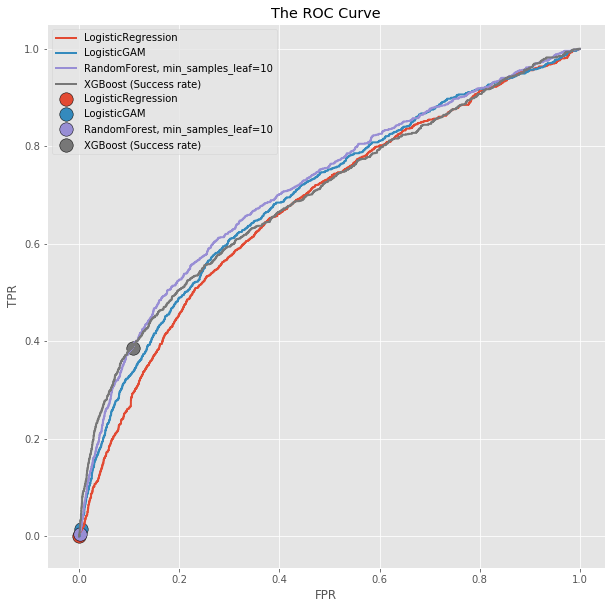

In [173]:
%%capture --no-stdout --no-display
table, fig, ax = fit_and_compare(
    clfs, X_train, y_train, 
    X_valid, y_valid)
print(table)

Fitting LogisticRegression...
Fitting LogisticGAM...
Fitting RandomForest, min_samples_leaf=10...
Fitting XGBoost (Success rate)...
clf                                  misclf rate    oob error       auc    top1k success
---------------------------------  -------------  -----------  --------  ---------------
LogisticRegression                      0.118766   nan         0.656059            0.262
LogisticGAM                             0.118987   nan         0.68213             0.311
RandomForest, min_samples_leaf=10       0.118655     0.117636  0.703864            0.331
XGBoost (Success rate)                  0.154484   nan         0.698691            0.361


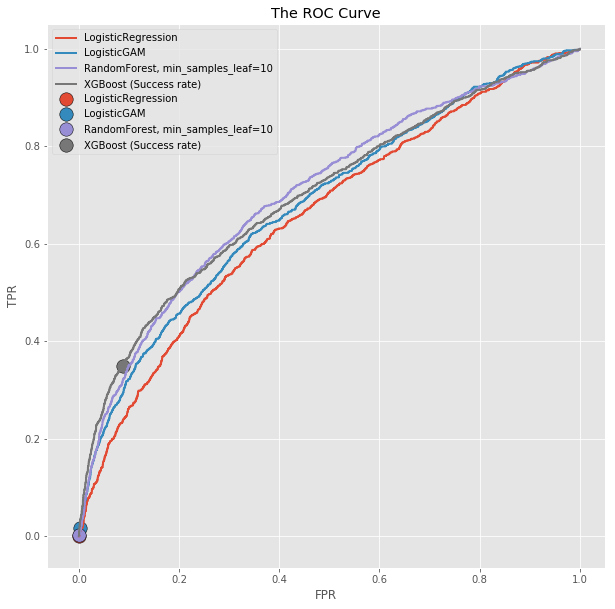

In [169]:
%%capture --no-stdout --no-display
table, fig, ax = fit_and_compare(
    clfs, X_train, y_train, 
    X_test, y_test)
print(table)

In [ ]:
RandomForest, min_samples_leaf=10       0.118655     0.117636  0.703864            0.331

In [ ]:
clfs = [
    ('LogisticRegression', LogisticRegression(C=10e5)),
    ('LogisticGAM', LogisticGAM()),
    ('RandomForest, min_samples_leaf=10', 
     RandomForestClassifier(
         min_samples_leaf=10, n_estimators=500, 
         oob_score=True, random_state=1, n_jobs=-1)),
    ('XGBoost (Success rate)', XGBClassifier(
        n_estimators=55, scale_pos_weight=2.9,
        max_depth=8, gamma=1.8, learning_rate=0.1,
        subsample=1, reg_lambda=1.05
    ))
]